# RealSim-IFS Tutorial: Generating synthetic MaNGA data

Welcome to the RealSim-IFS tutorial. In this tutorial, we will generate some MaNGA-like synthetic kinematic data using a line-of-sight (LOS) velocity cube for a disk galaxy from the TNG50-1 simulation. The main requirements of RealSim-IFS are the `astropy`, `numpy`, and `progress` packages. Please install these modules before starting this tutorial.

In [1]:
import os,sys,time
from realsim import ifs as rifs

realsim_dir = os.path.dirname(rifs.__file__)
losvd_dir = f'{realsim_dir}/Data/LOSVD' 

The data used in this tutorial is a LOS velocity distribution cube with 4 km/s velocity resolution in a [-500,500] km/s range and physical spatial resolution of 200 pc/pixel (assuming $h=0.6774$). Plots of mass surface density, velocity, and velocity dispersion are shown below for a random line-of-sight. These calculations assume single-component gaussian velocity distributions -- which is generally a poor assumption but is illustrative. **Input must be organized such that the first axis is the velocity/wavelength dimension and the second and third are the spatial axes.**

### 1. Idealized cubes LOSVD cubes
Use the `losvd_moments` convenience function to compute the first three LOSVD moments (total mass (or intensity), velocity, and velocity dispersion.

LOSVD cube shape: (250, 96, 96)


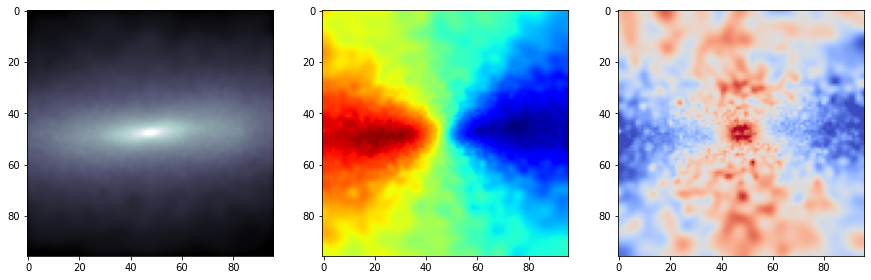

In [2]:
from astropy.io import fits
import matplotlib.pyplot as plt
import numpy as np

losvd_name = f'{losvd_dir}/losvd_TNG50-1_091_119450_stars_v0__32.fits'
fig,axarr = plt.subplots(1,3,figsize=(15,5))

with fits.open(losvd_name) as hdu:
    
    losvd = hdu[0].data.transpose(2,0,1) # <-- note transpose
    print(f'LOSVD cube shape: {losvd.shape}')
    hdr = hdu[0].header
    kpc_per_pixel = hdr['fov_kpc']/hdr['npixel']
    vlim,delv,nvels = hdr['vlim'],hdr['delv'],hdr['nvaxel']
    
    mass_density,vbar,vdisp = rifs.losvd_moments(losvd,kpc_per_pixel,
                                                        vlim,delv,nvels)
    axarr[0].imshow(mass_density,cmap='bone',vmin=6,vmax=10)
    axarr[1].imshow(vbar,cmap='jet',vmin=-150,vmax=150)
    axarr[2].imshow(vdisp,cmap='coolwarm',vmin=50,vmax=100)

This disk-dominated galaxy is rotating rapidly and has a small but prominent kinematic bulge. Halo stars also have high velocity dispersions. Meanwhile, the disk of the galaxy is dynamically cold. 

Note that the velocities and velocity dispersions are defined everywhere on the grid -- even where the masses are arbitrarily small. This is a result of the smoothing of discrete point particles (which represent unresolved stellar populations or the centres of mass of gas parcels) onto the Cartesian spatial grid.

### 2. Setting up the MaNGA observation

Start by generating the atmospheric seeing (atmospheric Point Spread Function; PSF) conditions using the `manga_seeing` function.

In [3]:
seed = 12345
seeing_arcsec = rifs.manga_seeing(seed=seed)
print(f'PSF FWHM: {seeing_arcsec:.3f} arcsec')

PSF FWHM: 1.657 arcsec


We will mock-observe this galaxy at redshift $z=0.04$ in this example -- which is the median redshift of the MaNGA target list. Alternatively, the `manga_redshift` can also be used, which draws from the MaNGA sample redshift distribution.

In [4]:
redshift = 0.04
# redshift = rifs.manga_redshift(seed)
print(f'Redshift: {redshift:0.3f}')

Redshift: 0.040


### 3. Seeing-convolved data cube

Before reaching any instrumental components, light is blurred by the atmospheric PSF. Since we are assuming that light tracks mass in our mass-weighted LOSVD cubes, the atmospheric PSF is applied spatially in every velocity channel. Therefore, the next step is to convolve the cube with the atmospheric PSF. For this, we use the general `apply_seeing` function (not MaNGA specific). Since the cubes are in physical units and the PSF FHWM is in angular units, the function requires and `astropy.cosmology` instance (default Planck15), and the spatial characteristics of the data. It then uses the angular diameter distance at `redshift`, and the physical resolution of the image to convert the seeing to physical units. Finally, it does the convolution slice-by-slice.

In [5]:
from astropy.cosmology import Planck15 as cosmo
losvd_conv = rifs.apply_seeing(losvd,kpc_per_pixel,redshift,
                                      seeing_model='manga',
                                      seeing_fwhm_arcsec=seeing_arcsec,
                                      cosmo=cosmo)

The `seeing_model` keyword has two options with `manga` as the default option. In the MaNGA seeing model, the seeing model is the superposition of two Gaussian components. See the doc-string for `apply_seeing` for more details.

The LOSVD moments derived from the seeing-convolved cube is shown below. The grid resolution and units of the cube are unchanged. Only the seeing has changed. So the same keyword arguments are used.

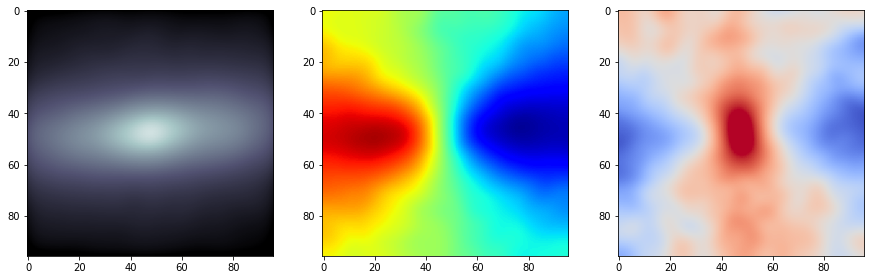

In [6]:
mass_density,vbar,vdisp = rifs.losvd_moments(losvd_conv,kpc_per_pixel,
                                                    vlim,delv,nvels)
fig,axarr = plt.subplots(1,3,figsize=(15,5))
axarr[0].imshow(mass_density,cmap='bone',vmin=6,vmax=10)
axarr[1].imshow(vbar,cmap='jet',vmin=-150,vmax=150)
axarr[2].imshow(vdisp,cmap='coolwarm',vmin=50,vmax=100)

*Note that in general some total mass (intensity) will be lost in the convolution as it is spread beyond the edge of the FOV.*

### 4. Choosing the IFU design

MaNGA has 6 different IFU designs (bundles). Each IFU design and their (dithered exposure) observing pattern can be reproduced with the `manga_ifu` function. The names of each design denote the number of fibers in the corresponding bundle. MaNGA uses 3 dithered exposures for a complete footprint. In real observations, the dithered exposures would be taken multiple times. But since the astrometric precision for repeat exposures on the milli-arcsec level, it is unnecessary to take more than 3 exposures for the synthetic data.

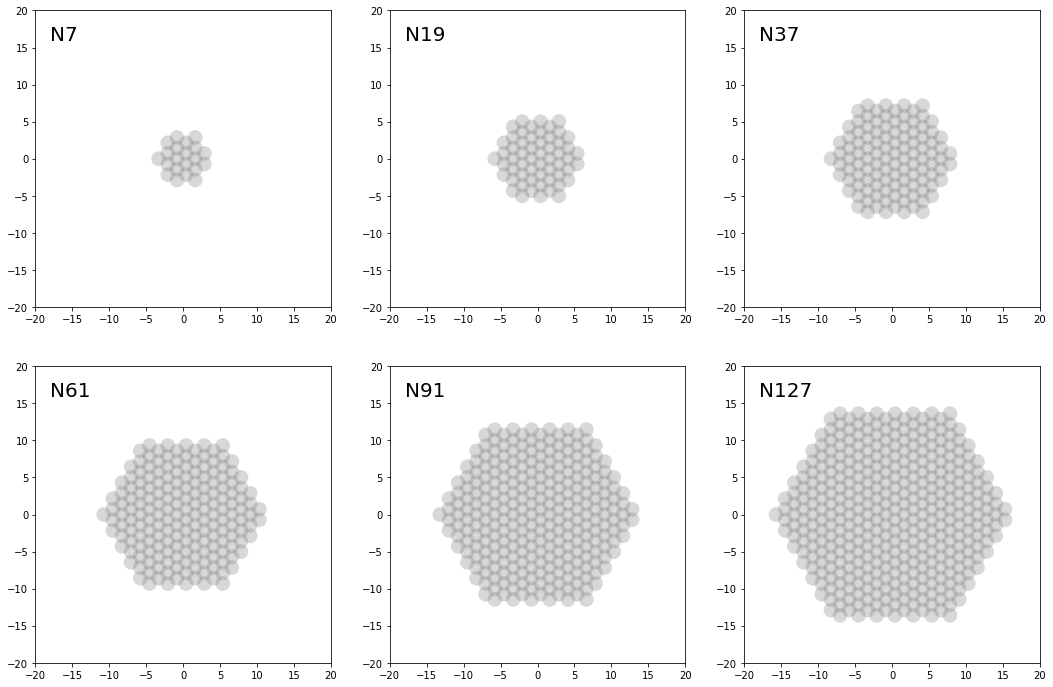

In [7]:
bundle_names = ['N7','N19','N37','N61','N91','N127']

fig,axarr = plt.subplots(2,3,figsize=(18,12))
axarr = axarr.flatten()
fig.subplots_adjust(hspace=0.2,wspace=0.2)

from matplotlib.patches import Circle

for i,bundle_name in enumerate(bundle_names):
    ax = axarr[i]
    ax.set_xlim(-20,20) # arcsec
    ax.set_ylim(-20,20) # arcsec
    ax.text(0.05,0.95,bundle_name,transform=ax.transAxes,
            ha='left',va='top',fontsize=20)
    
    (xc_arcsec,yc_arcsec),params = rifs.manga_ifu(bundle_name=bundle_name,
                                                  rotation_degrees=0.)
    
    fiber_diameter_arcsec = params['fiber_diameter_arcsec']
    core_diameter_arcsec = params['core_diameter_arcsec']
    n_observations = params['n_observations']
    
    for i_obs in range(n_observations):
        xc_obs,yc_obs = xc_arcsec[:,i_obs],yc_arcsec[:,i_obs]
        for xy in zip(xc_obs,yc_obs):
            core = Circle(xy=xy, radius=core_diameter_arcsec/2,
                          transform=ax.transData, edgecolor='None',
                          facecolor='Grey', alpha=0.3)
            ax.add_artist(core)

*Note that the N7 design is not generally used for observing and is reserved for calibrations.*

The `manga_ifu` function creates arrays which give the $x$ anc $y$ coordinates of each fiber centroid in a MaNGA IFU design. Additionally, the `params` dictionary contains other important/useful properties of the fibers, design, and observing pattern. For example, the `'core_diameter_arcsec'` key gives the common diameter of each fiber core.

We now need to pick which IFU design is most suitable. MaNGA IFUs are assigned such that they cover a certain fraction of the galaxy light. We will pick the IFU which extends to 2.5 times the galaxy half-mass radius (stellar particle [partNum 4] SubhaloHalfMassRadType in the TNG group catalogues). Galaxies in the Secondary MaNGA target sample get this coverage. The FOV of the cube is 6 subhalo half-mass radii. So the best design is the one whose physical size at `redshift` is closest to 5 half-mass radii. In the example cube header, the `'fovunit'` keyword is `'rhalf'` and the `'fovsize'` keyword is 6.

In [8]:
# ifu footprints in arcsec
footprints = {'N19':12.5,'N37':17.5,'N61':22.5,'N91':27.5,'N127':32.5} 

bundle_names = np.array(list(footprints.keys()))
bundle_footprints = np.array(list(footprints.values()))
nrhalf = 2.5

rhalf_kpc = hdr['fov_kpc']/hdr['fovsize']
print(f'Half-mass Radius: {rhalf_kpc:.3f} kpc')

from astropy.cosmology import Planck15 as cosmo
kpc_per_arcsec = cosmo.kpc_proper_per_arcmin(z=redshift).value/60. 

rhalf_arcsec = rhalf_kpc / kpc_per_arcsec
fov_min = 2*nrhalf*rhalf_arcsec
print(f'Half-mass Radius:', f'2 x {nrhalf} x {rhalf_arcsec:.3f} = ',
      f'{fov_min:0.3f} arcsec at z={redshift:0.3f}')

# find ifu with smallest difference
bundle_idx = np.argmin(np.abs(bundle_footprints-fov_min))
while bundle_footprints[bundle_idx]<fov_min:
    bundle_idx+=1

bundle_name = bundle_names[bundle_idx]
print(f'Optimized IFU design: {bundle_name}')
print(f'Footprint: {footprints[bundle_name]} arcsec')

Half-mass Radius: 3.230 kpc
Half-mass Radius: 2 x 2.5 x 3.950 =  19.752 arcsec at z=0.040
Optimized IFU design: N61
Footprint: 22.5 arcsec


### 5. Applying the selected IFU design

Start by setting up the fiber positions and parameters for this design. As mentioned earlier, the `manga_ifu` function creates arrays for the fiber coordinates and a `params` dictionary containing ancillary information about the observation pattern. Note that the core arrays are converted from arcseconds to cube pixel units in this step. Below, the IFU design is shown overlaid on the moment maps.

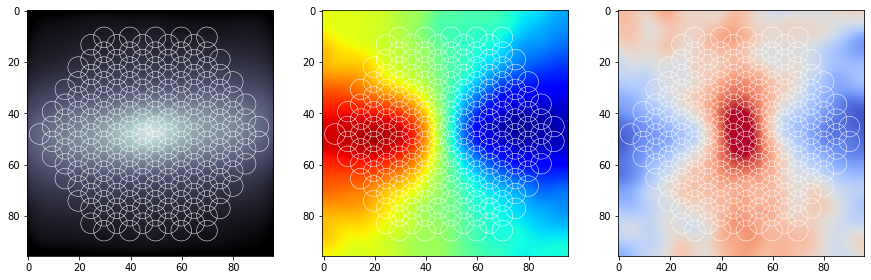

In [9]:
(xc_arcsec,yc_arcsec),params = rifs.manga_ifu(bundle_name=bundle_name,rotation_degrees=0.)
fiber_diameter_arcsec = params['fiber_diameter_arcsec']
core_diameter_arcsec = params['core_diameter_arcsec']
n_observations = params['n_observations']

# coordinate change to convert to pixel
arcsec_per_pixel = kpc_per_pixel/kpc_per_arcsec
xc_pixels = (xc_arcsec/arcsec_per_pixel+losvd_conv.shape[2]/2.).flatten()
yc_pixels = (yc_arcsec/arcsec_per_pixel+losvd_conv.shape[1]/2.).flatten()
core_diameter_pixels = core_diameter_arcsec/arcsec_per_pixel 

fig,axarr = plt.subplots(1,3,figsize=(15,5))
axarr[0].imshow(mass_density,cmap='bone',vmin=6,vmax=10)
axarr[1].imshow(vbar,cmap='jet',vmin=-150,vmax=150)
axarr[2].imshow(vdisp,cmap='coolwarm',vmin=50,vmax=100)

for ax in axarr:
    for xy in zip(xc_pixels,yc_pixels):
        core = Circle(xy=xy, radius=core_diameter_pixels/2,
                      transform=ax.transData,edgecolor='white',
                      facecolor='None',lw=0.5)
        ax.add_artist(core)

Now 'observe' the cube with the selected design using the generalized `ifu_observe` function. This function takes the seeing-convolved cube, and the pixel-coordinates and diameters of the IFU fibers.

In [10]:
core_arrays = rifs.ifu_observe(losvd_conv, xc_pixels, yc_pixels, 
                               core_diameter_pixels)
print(core_arrays.shape)

(183, 250)


The `ifu_observe` essentially produces data in Row-Stacked Spectra (RSS) file format which will be familar to MaNGA users. Each row corresponds to a single fiber and contains the line-of-sight velocity distribution captured by that fiber in pixels which are fully or partially within its aperture.

### 6. Spatial reconstruction of fiber measurements

The final step is to reconstruct the fiber measurements onto a Cartesian grid. The `ifu_to_grid` function handles this task. There are many options for this reconstruction which follow from various data reduction pipelines. MaNGA uses the Modified Shepard algorithm. Full details are in the docstring and the paper. 

First, the output grid is set up. The largest MaNGA IFU design is 32.5 arcsec in diameter. So a (70,70) grid with 0.5 arcsec per spaxel is guaranteed to encompass all IFU designs. The output grid sizes should be optimized to each IFU design to prevent wasted storage. The core positions and diameters are converted to the coordinate system of this output grid. These new coordinates are then passed to the `ifu_to_grid` function alongside the core arrays from the previous step. The `use_gaussian_weights` keyword causes the function to use the Modified Shepard algorithm to in the spatial reconstruction of the fiber intensities. The other option is the Inverse Drizzle Algorithm, which essentially reverses the functionality of `ifu_observe`. For details see the docstring and the paper.

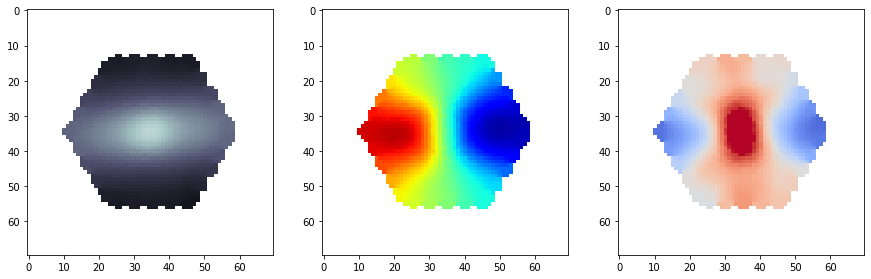

In [12]:
manga_grid_dims = (70,70)
manga_arcsec_per_pixel = 0.5
manga_kpc_per_pixel = kpc_per_arcsec*manga_arcsec_per_pixel
manga_xc_pixels = xc_arcsec/manga_arcsec_per_pixel + manga_grid_dims[1]/2.
manga_yc_pixels = yc_arcsec/manga_arcsec_per_pixel + manga_grid_dims[0]/2.
manga_core_diameter_pixels = core_diameter_arcsec/manga_arcsec_per_pixel

losvd_manga,weight_map = rifs.ifu_to_grid(
    core_arrays, 
    manga_xc_pixels, 
    manga_yc_pixels, 
    manga_core_diameter_pixels, 
    grid_dimensions_pixels=manga_grid_dims, 
    use_gaussian_weights=True,
    use_broadcasting=True
)

losvd_manga[losvd_manga==0.]=np.nan

mass_density,vbar,vdisp = rifs.losvd_moments(losvd_manga, manga_kpc_per_pixel,
                                             vlim, delv, nvels)
fig,axarr = plt.subplots(1,3,figsize=(15,5))
axarr[0].imshow(mass_density,cmap='bone',vmin=6,vmax=10)
axarr[1].imshow(vbar,cmap='jet',vmin=-150,vmax=150)
axarr[2].imshow(vdisp,cmap='coolwarm',vmin=50,vmax=100)

The resulting output cubes now incorporate the MaNGA observing strategy, footprint, and atmospheric point spread function. There are many other steps that could be added. For example, a line-spread function can be applied after Step 5 to incorporate realistic spectral resolution. Signal-to-noise considerations can be made using mass surface density as a proxy for signal and S/N typical of observations. Etc.

The generalized functions in RealSim-IFS such as `apply_seeing`, `ifu_observe`, and `ifu_to_grid` can be applied to any IFU design and observing strategy including those with fibers of multiple sizes. All that is needed are the fiber coordinate arrays and diameters. Similarly, RealSim-IFS can be used on spectral flux datacubes as this process is mathematically equivalent to LOSVD cubes. This is one of the main rationale for RealSim-IFS -- since it is much closer to the real data.

This concludes the RealSim-IFS MaNGA tutorial. In this tutorial, we used mock-observed the target galaxy at redshift $z=0.04$. The N61 design footprint is optimized for capturing the galaxy light out to at least 2.5 half-mass radii. Lowering the redshift will make the galaxy's angular size larger -- requiring a larger design. Setting $z=0.025$ in Section 2 above will result in the N127 design being used. Try it. 

### Appendix A: Implementing the SAMI IFU design

The SAMI IFU design has also been given a dedicated function in RealSim-IFS. The plot below shows the footprint of a single SAMI fiber bundle (left) and the footprint of 7 dithered SAMI exposures (right). The SAMI `xc_arr`, `yc_arr`, and `params` can be easily implemented as a replacement for the above MaNGA tutorial. Note that SAMI use the Inverse Drizzle Algorithm in their data reduction pipeline (Sharp et al. 2015).

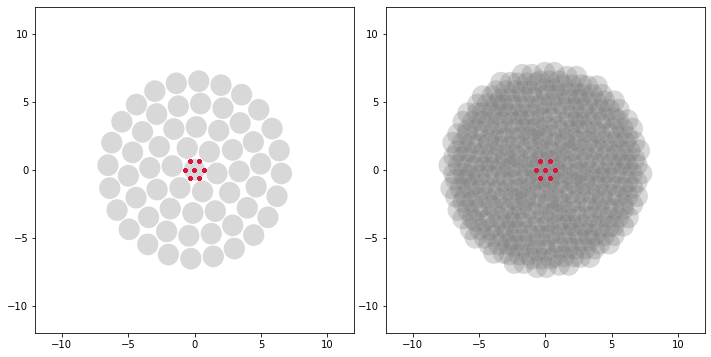

In [13]:
fig,axarr = plt.subplots(1,2,figsize=(12,6))
fig.subplots_adjust(wspace=0.1,)

for ax in axarr:
    ax.set_xlim(-12,12)
    ax.set_ylim(-12,12)

(xc_arr,yc_arr),params = rifs.sami_ifu(rotation_degrees=0)

common_args = {'radius':params['core_diameter_arcsec']/2.,
               'facecolor':'Grey', 'alpha':0.3, 'zorder':0}

ax = axarr[0]
xc,yc = xc_arr[:,0],yc_arr[:,0]
for fiber in range(params['fibers_in_bundle']):
        ax.add_artist(Circle(xy=(xc[fiber],yc[fiber]),**common_args))
        
ax = axarr[1]
idx_center = 30
for exposure in range(params['n_observations']):
    xc,yc = xc_arr[:,exposure],yc_arr[:,exposure]
    for fiber in range(params['fibers_in_bundle']):
        ax.add_artist(Circle(xy=(xc[fiber],yc[fiber]),**common_args))
        axarr[0].scatter(xc[idx_center],yc[idx_center],
                         c='crimson',s=10,zorder=1)
        axarr[1].scatter(xc[idx_center],yc[idx_center],
                        c='crimson',s=10,zorder=1)

The crimson markers show the position of the central fiber in each of the 7 dithered exposures.